## Dataset Description
### First give a brief introduction to all attributes in the dataset we use:



### People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if customer complained in the last 2 years, 0 otherwise

### Products

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years


### Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

### Place

- NumWebPurchases: Number of purchases made through the company’s web site
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s web site in the last month

In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sns

In [2]:
#Loading the dataset
data = pd.read_csv("./marketing_campaign.csv", sep="\t")
print("shape of data : ", data.shape)
data.head()

shape of data :  (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In the next step, I am going to create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database.

However, in order to keep it simple, I am taking this value relative to the most recent customer in the record.

Thus to get the values I must check the newest and oldest recorded dates.

Creating a feature ("Customer_For") of the number of days the customers started to shop in the store relative to the last recorded date.

In [4]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

# Created a feature "Customer_For"
days = []
d1 = max(dates) # taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta.days)

data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"]) # , errors="coerce"

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [5]:
data["Customer_For"].describe()

count    2216.000000
mean      512.006318
std       232.469034
min         0.000000
25%       340.000000
50%       513.000000
75%       686.000000
max      1063.000000
Name: Customer_For, dtype: float64

In [6]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.

-> 생년월일을 이용해 만듬

Create another feature "Spent" indicating the total amount spent by the customer in various categories
over the span of two years.

-> Gold 매출을 제외하고 식료품 매출을 만듬 ( regression에 사용 )

Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.

-> absurd, yolo 제외하고 partner / alone으로 구분한 "Living_With" 를 만들어줌

Create a feature "Children" to indicate total children in a household that is, kids and teenagers.

-> 아이가 있는지 여부

To get further clarity of household, Creating feature indicating "Family_Size"

-> 가족 규모를 구함. partner(2명) + 아이 수 / alone(1명) + 아이 수

Create a feature "Is_Parent" to indicate parenthood status

->  "Children"이 있으면 1 아니면 0
Lastly, I will create three categories in the "Education" by simplifying its value counts.

Dropping some of the redundant features

-> 파생변수를 만드는데 사용한 변수와 필요 없는 변수들 drop!

( "Dt_Customer", "Marital_Status", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID", "MntGoldProds" ) 를 날림.

In [7]:
#Feature Engineering

# Age of customer today 
data["Age"] = 2021 - data["Year_Birth"]

# Total spendings on various items
# + data["MntGoldProds"] : 식품 소비만을 target으로 잡는다!

data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] \
+ data["MntFishProducts"] + data["MntSweetProducts"]


# drop Marital_Status column isin (Absurd, YOLO) f: not clearly defined!
data = data.loc[~data['Marital_Status'].isin(['Absurd','YOLO'])]


# Deriving living situation by marital status"Alone"
data["Living_With"] = data["Marital_Status"].replace({"Married":"Partner",
                                                      "Together":"Partner",
                                                      "Widow":"Alone",
                                                      "Divorced":"Alone",
                                                      "Single":"Alone",})

# Feature indicating total children living in the household
data["Children"]= data["Kidhome"] + data["Teenhome"]

# Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2}) + data["Children"]

# Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

# Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate",
                                             "2n Cycle":"Undergraduate",
                                             "Graduation":"Graduate",
                                             "Master":"Postgraduate",
                                             "PhD":"Postgraduate"})

# For clarity 
# "MntGoldProds":"Gold" 제외
data=data.rename(columns={"MntWines": "Wines",
                          "MntFruits":"Fruits",
                          "MntMeatProducts":"Meat",
                          "MntFishProducts":"Fish",
                          "MntSweetProducts":"Sweets"})

# Dropping some of the redundant features : "Dt_Customer" -> "Customer_for" ,  "Marital_Status" -> "Living_with"
to_drop = ["Dt_Customer", "Marital_Status", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID", "MntGoldProds"]
data = data.drop(to_drop, axis=1)

In [8]:
data.dtypes

Education               object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
Wines                    int64
Fruits                   int64
Meat                     int64
Fish                     int64
Sweets                   int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Customer_For             int64
Age                      int64
Spent                    int64
Living_With             object
Children                 int64
Family_Size              int64
Is_Parent                int32
dtype: object

In [9]:
## category로 one-hot encoding된 것들이 int로 표시되어 있어서 바꿔줌

to_cat_list = ['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Is_Parent','Complain']

for col in to_cat_list:
    data[col] = data[col].astype('object')


In [10]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,52232.510850,0.442586,0.505425,49.050633,305.030741,26.324593,166.970163,37.516275,27.047468,2.321429,4.083183,2.668174,5.800181,5.320072,511.873870,52.188969,562.889241,0.948011,2.594485
std,25187.455359,0.537052,0.544258,28.940794,337.611255,39.781794,224.344950,54.558673,41.092454,1.923511,2.741930,2.924378,3.253616,2.423445,232.306146,11.982065,577.537581,0.749196,0.905097
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,4.000000,0.000000,1.000000
25%,35233.500000,0.000000,0.000000,24.000000,23.750000,1.750000,16.000000,3.000000,1.000000,1.000000,2.000000,0.000000,3.000000,3.000000,340.000000,44.000000,55.000000,0.000000,2.000000
50%,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,68.000000,12.000000,8.000000,2.000000,4.000000,2.000000,5.000000,6.000000,513.000000,51.000000,341.500000,1.000000,3.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.500000,33.000000,232.250000,50.000000,33.000000,3.000000,6.000000,4.000000,8.000000,7.000000,685.000000,62.000000,964.000000,1.000000,3.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1063.000000,128.000000,2491.000000,3.000000,5.000000


### Age와 Income의 Outlier를 제거하기 위한 근거를 찾는 부분 (boxplot, density plot, scatter plot)

19it [00:00, 48.22it/s]


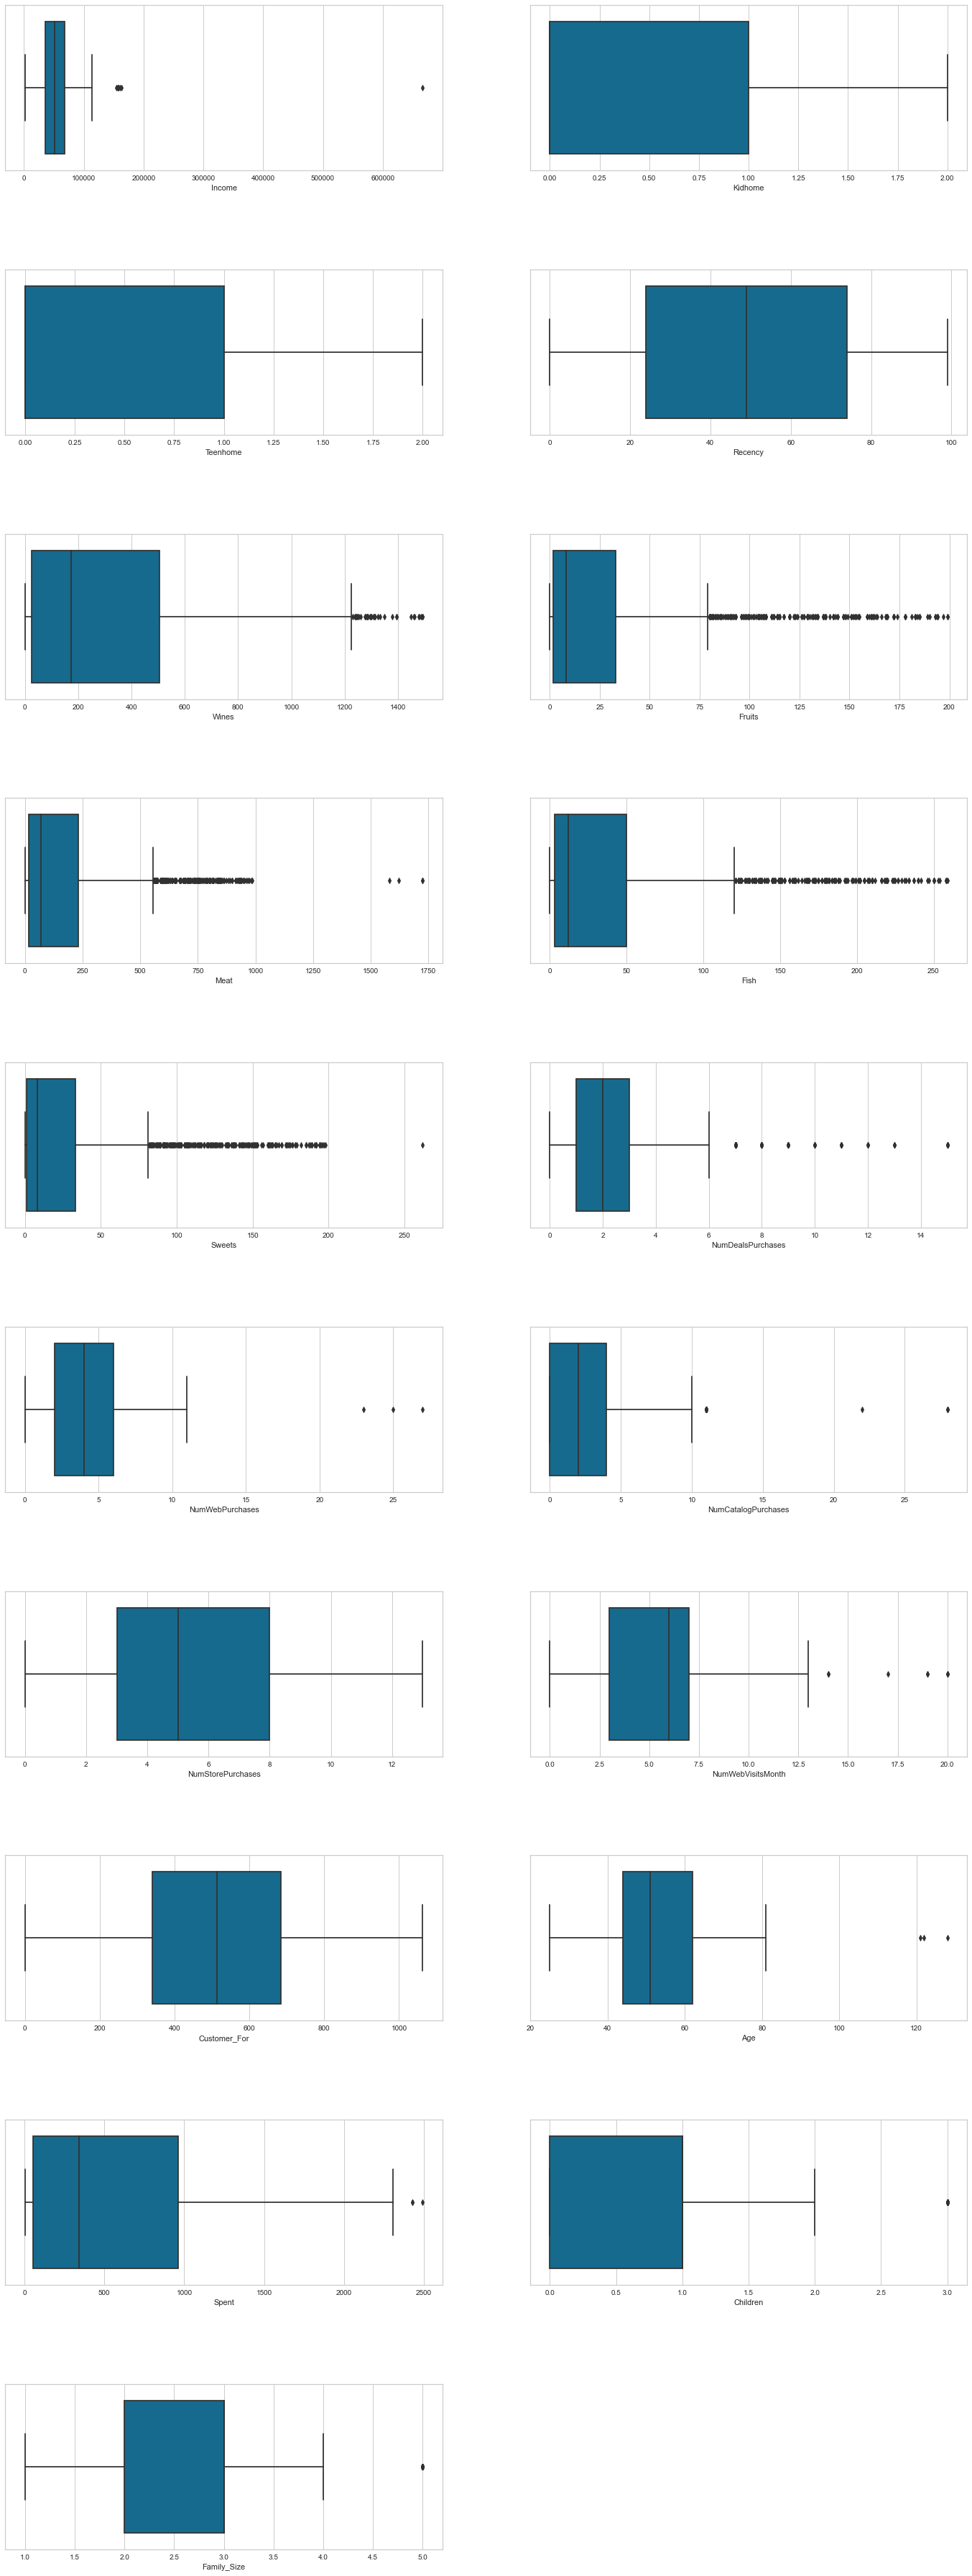

In [11]:
from tqdm import tqdm

fig = plt.figure(figsize=(24, 42*3))

conti_list = data.describe().columns.tolist()

for i, col in tqdm(enumerate(conti_list)):
    plt.subplot(len(conti_list), 2, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    sns.boxplot(data[col])

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 576x396 with 0 Axes>

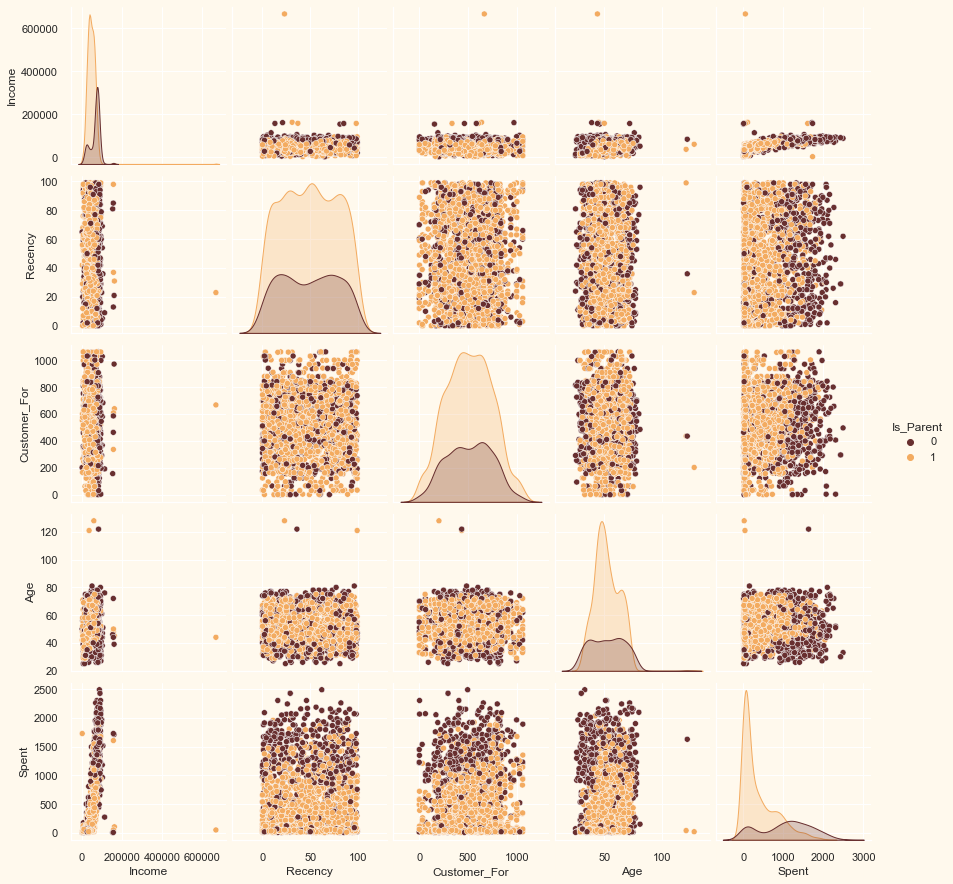

In [12]:
# To plot some selected features 
# Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
# Plotting following features
To_Plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [13]:
## Clearly, there are a few outliers in the Income and Age features -> deleting the outliers in the data.

data = data[(data["Age"]<90)] # 3개 제거
data = data[(data["Income"]<600000)] # 1개 제거

print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2208


In [70]:
#correlation matrix 
# corrmat= data.corr()
# plt.figure(figsize=(20,20))  
# sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

## preprocessing the data to perform clustering operations.

### The following steps are applied to preprocess the data:

- Label encoding the categorical features ( clustering 적용 위해 )
- Scaling the features using the standard scaler ( PCA는 scale-variant! 그래서 표준화 해줌 )
- Creating a subset dataframe for dimensionality reduction ( multicollinearity Issue 발생 막기 위해 )

In [14]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Living_With', 'Is_Parent']


In [15]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [16]:
# creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

In [17]:
pd.set_option('display.max.columns', 30)
ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,0,58138.0,0,0,58,635,88,546,172,88,3,8,10,4,7,971,64,1529,0,0,1,0
1,0,46344.0,1,1,38,11,1,6,2,1,2,1,1,2,5,125,67,21,0,2,3,1
2,0,71613.0,0,0,26,426,49,127,111,21,1,8,2,10,4,472,56,734,1,0,2,0
3,0,26646.0,1,0,26,11,4,20,10,3,2,2,0,4,6,65,37,48,1,1,3,1
4,1,58293.0,1,0,94,173,43,118,46,27,5,5,3,6,5,321,40,407,1,1,3,1


In [18]:
# Scaling
scaler = StandardScaler()
scaled_ds = pd.DataFrame(scaler.fit_transform(ds), columns=ds.columns)
print("All features are now scaled")

All features are now scaled


In [19]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.892765,0.287689,-0.824004,-0.929587,0.309118,0.977018,1.553315,1.689944,2.464405,1.482521,0.352174,1.427120,2.506603,-0.555083,0.692301,1.975537,1.017915,1.673508,-1.353059,-1.265454,-1.761762,-1.582644
1,-0.892765,-0.260057,1.038228,0.907950,-0.382230,-0.871705,-0.636864,-0.717917,-0.651086,-0.634157,-0.167612,-1.125249,-0.570823,-1.169892,-0.133077,-1.665742,1.274437,-0.939294,-1.353059,1.403240,0.447193,0.631854
2,-0.892765,0.913505,-0.824004,-0.929587,-0.797039,0.357814,0.571511,-0.178378,1.346494,-0.147565,-0.687398,1.427120,-0.228887,1.289346,-0.545767,-0.172215,0.333858,0.296069,0.739066,-1.265454,-0.657284,-1.582644
3,-0.892765,-1.174887,1.038228,-0.929587,-0.797039,-0.871705,-0.561341,-0.655491,-0.504474,-0.585498,-0.167612,-0.760624,-0.912759,-0.555083,0.279612,-1.923989,-1.290779,-0.892513,0.739066,0.068893,0.447193,0.631854
4,0.571741,0.294887,1.038228,-0.929587,1.553545,-0.391748,0.420464,-0.218509,0.155277,-0.001587,1.391746,0.333248,0.113050,0.059727,-0.133077,-0.822136,-1.034258,-0.270500,0.739066,0.068893,0.447193,0.631854


In [24]:
scaled_ds.shape

(2208, 22)

## DIMENSIONALITY REDUCTION ( The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant.)

- In this problem, there are many factors on the basis of which the final classification will be done.These factors are basically attributes or features.

- This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier.

- Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

- Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets,
increasing interpretability but at the same time minimizing information loss.

> Steps in this section:

- Dimensionality reduction with PCA
- Plotting the reduced dataframe
- Dimensionality reduction with PCA

For this project, I will be reducing the dimensions to 3.

In [22]:
cov_mat=np.cov(scaled_ds.T)
eigen_vals,eigen_vecs=np.linalg.eig(cov_mat)
print('Eigenvalue of X variables ! \n %s'% eigen_vals)

Eigenvalue of X variables ! 
 [ 8.00903824e+00  2.86683608e+00  1.46356584e+00  1.31476268e+00
  1.10334549e+00  1.00831513e+00  9.42226874e-01  8.38249333e-01
  7.39799360e-01  6.24227460e-01  5.61991582e-01  1.75005581e-01
  2.00510309e-01  2.42181652e-01  2.80037878e-01  3.56760919e-01
  4.52351684e-01  4.30769229e-01  3.99992968e-01 -2.66389905e-15
  1.16486351e-16 -3.20282888e-16]


In [23]:
len(eigen_vals)

22

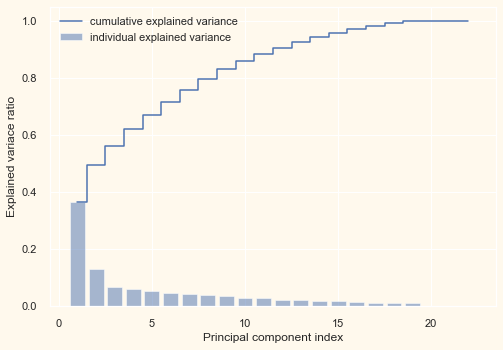

In [39]:
## PCA로 설명되는 분산을 계산하고 plotting!!

tot=sum(eigen_vals)
var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)]

cum_var_exp=np.cumsum(var_exp)

plt.bar(range(1,23), var_exp, alpha=0.5, label='individual explained variance')
plt.step(range(1,23),cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variace ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')

In [50]:
var_exp

[0.3638823160812466,
 0.13025171338665792,
 0.06649559059456367,
 0.05973487392868094,
 0.050129353733143145,
 0.04581174854283578,
 0.0428090972986092,
 0.03808498596051864,
 0.03361201388510089,
 0.028361124916566272,
 0.025533502585378044,
 0.020552127939962795,
 0.019571551557715984,
 0.018173264176370614,
 0.01620906102104647,
 0.012723229502946179,
 0.011003271272938795,
 0.009109977203527679,
 0.007951196412190362,
 5.292436093716003e-18,
 -1.4551719658356402e-17,
 -1.2103148051418718e-16]

In [43]:
cum_var_exp

array([0.36388232, 0.49413403, 0.56062962, 0.62036449, 0.67049385,
       0.7163056 , 0.75911469, 0.79719968, 0.83081169, 0.85917282,
       0.88470632, 0.90525845, 0.92483   , 0.94300326, 0.95921233,
       0.97193556, 0.98293883, 0.9920488 , 1.        , 1.        ,
       1.        , 1.        ])

In [89]:
# 1안 ) 분산 누적 설명량이 80% 이상 도달하는 9차원으로 축소!
# pca = PCA(n_components=9)
# pca.fit(scaled_ds)
# PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2","col3","col4","col5",
#                                                           "col6","col7","col8","col9"]))
# PCA_ds.describe().T

# 2안 ) 분산 설명량이 0.1 이하로 감소하는 3차원을 기준으로 축소
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2","col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2208.0,2.333077e-17,2.830024,-5.950254,-2.460341,-0.807119,2.326593,7.580860
col2,2208.0,6.938894e-17,1.693173,-4.300208,-1.310067,-0.142702,1.212204,5.978147
col3,2208.0,4.384576e-17,1.209779,-3.589734,-0.850510,-0.020452,0.820250,6.688787


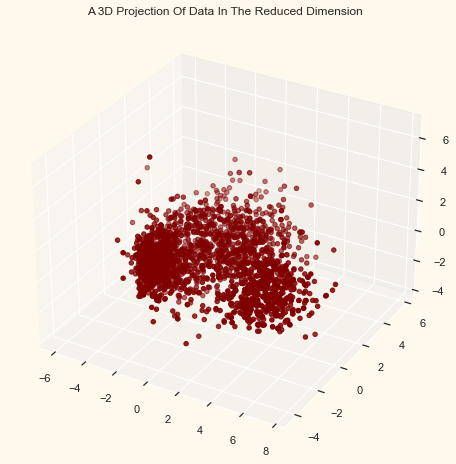

In [92]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Distortion score?
- 각 cluster 데이터 중심으로부터의 거리를 계산해서 더한 것! ( 낮을수록 좋음 )
- 거리는 일반적으로 l2 form 이용!

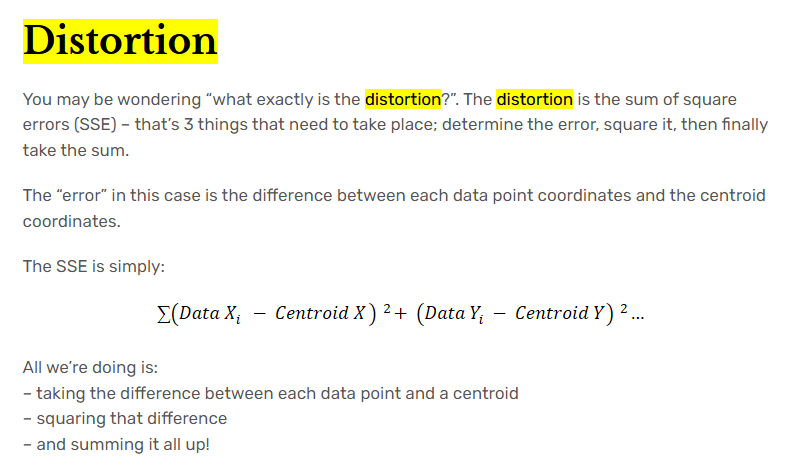
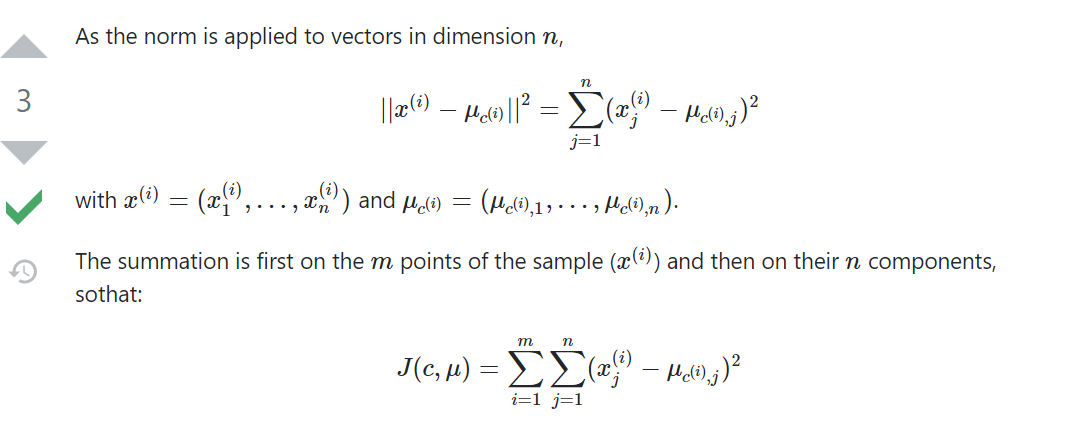

## CLUSTERING ( Distortion score 기준으로  clustering의 차원 결정! )

- Now that I have reduced the attributes to three dimensions, I will be performing clustering via Agglomerative clustering.
- Agglomerative clustering is a hierarchical clustering method.
- It involves merging examples until the desired number of clusters is achieved.

> Steps involved in the Clustering

- Elbow Method to determine the number of clusters to be formed
- Clustering via Agglomerative Clustering
- Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed:


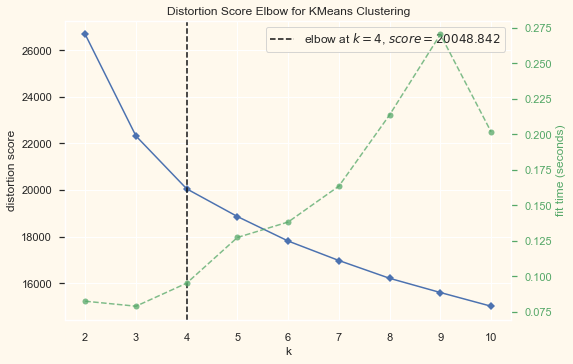

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
# 1안 ) Initiating PCA to reduce dimentions aka features to 9 -> 분산 누적 설명량이 80% 이상 도달하는 9차원으로 축소!
pca = PCA(n_components=9)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2","col3","col4","col5",
                                                          "col6","col7","col8","col9"]))
PCA_ds.describe().T

# 1안 ) 9차원으로 축소 / Distortion score : 20048.84

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10, metric = 'distortion')
Elbow_M.fit(PCA_ds)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed:


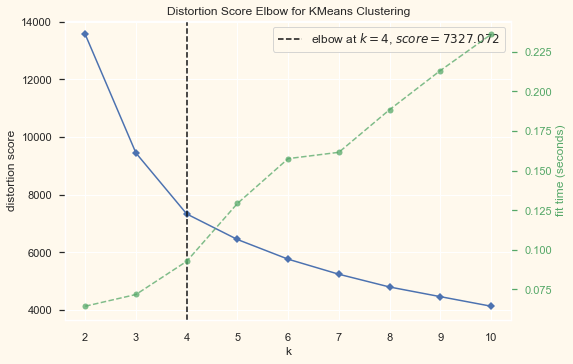

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [91]:
## 2안 ) 3차원으로 축소 / Distortion score : 7326.95 -> Distortion score 가 더 낮은 2안 선택
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2","col3"]))
PCA_ds.describe().T

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10, metric = 'distortion')
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [97]:
# Initiating the Agglomerative Clustering model -> 계층적 클러스터링 
# (Recursively merges the pair of clusters that minimally increases a given linkage distance.)
# 계층적 클러스터링 사용 이유? cluster의 거리 측정 기준인 linkage 선택 가능! 우리는 어느 정도의 크기가 있는 cluster 집단을 만들고 싶었다.
# 그래서 ward linkage 사용:
# Ward linkage?
# 모든 클러스터 내의 분산을 가장 작게 증가시키는 두 클러스터를 합침, 크기가 비교적 비슷한 클러스터가 만들어짐
# 선택 이유 : 일반적으로 가장 많이 사용되는 linkage이다. / 어느 정도의 크기가 있는 cluster 집단을 만들어야 의미가 있다고 판단.

AC = AgglomerativeClustering(n_clusters=4, linkage='ward')
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

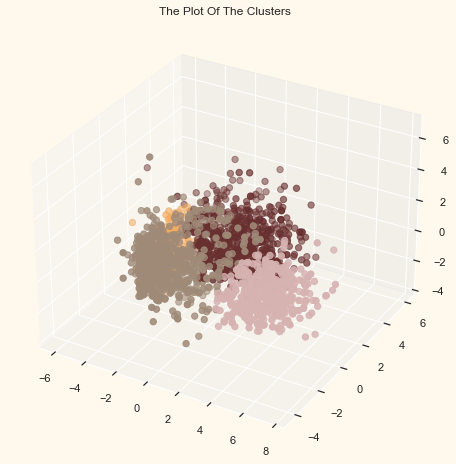

In [98]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

## EVALUATING MODELS


- Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model.

- The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

- For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

- Firstly, let us have a look at the group distribution of clustring


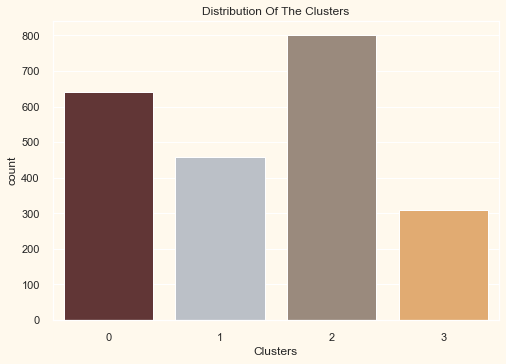

In [99]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

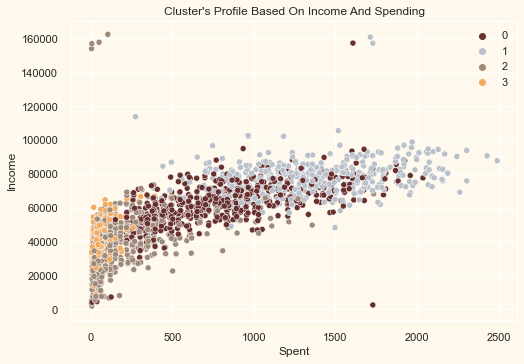

In [100]:
# Income vs spending plot shows the clusters pattern

# group 0: high spending & average income
# group 1: high spending & high income
# group 2: low spending & low income
# group 3: high spending & low income


pl = sns.scatterplot(data = data, x=data["Spent"], y=data["Income"],
                     hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

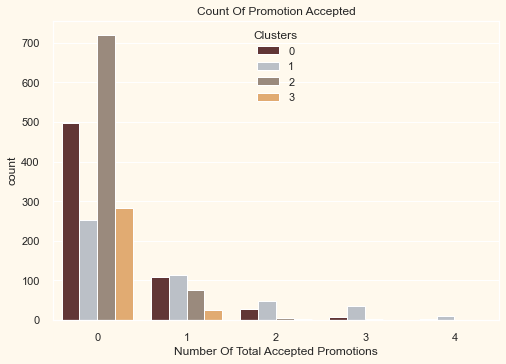

In [101]:
# There has not been an overwhelming response to the campaigns so far. Very few participants overall.
# Moreover, no one part take in all 5 of them. 
# Perhaps better-targeted and well-planned campaigns are required to boost sales.

# Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]

# Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

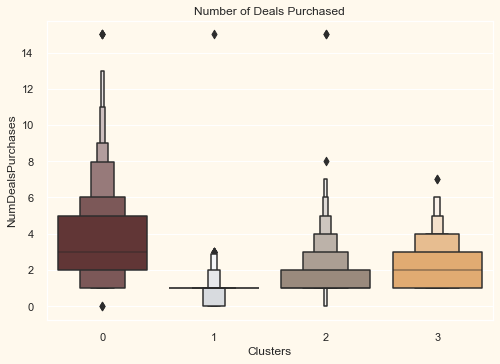

In [102]:
# Plotting the number of deals purchased
# Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. 
# However, our star customers cluster 1 are not much into the deals. Nothing seems to attract cluster 2 overwhelmingly

plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

## PROFILING


- Now that we have formed the clusters and looked at < their purchasing habits >.
- Let us see who all are there in these clusters. 
### For that, we will be profiling the clusters formed and come to a conclusion about 

### < who is our star customer > and < who needs more attention from the retail store's marketing team >.

- To decide that I will be plotting some of the features that are < indicative of the customer's personal traits > in light of the cluster they are in.

<Figure size 1728x1944 with 0 Axes>

<Figure size 576x396 with 0 Axes>

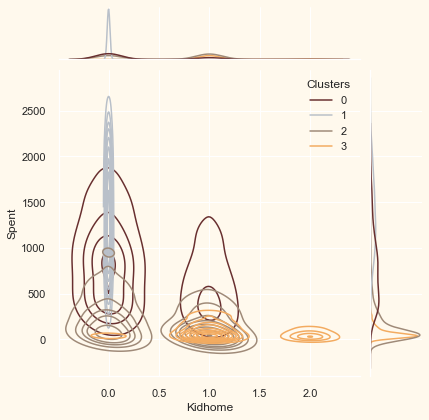

<Figure size 576x396 with 0 Axes>

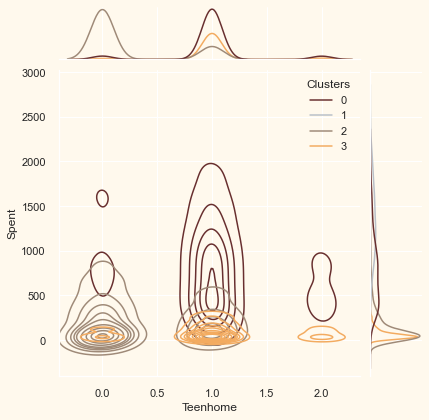

<Figure size 576x396 with 0 Axes>

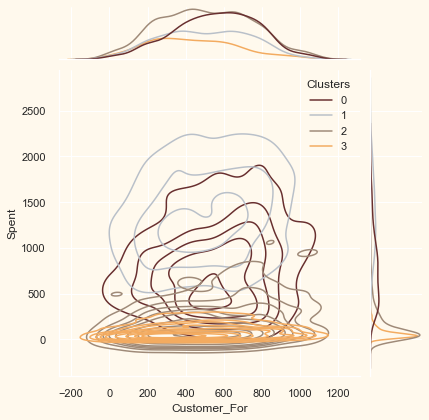

<Figure size 576x396 with 0 Axes>

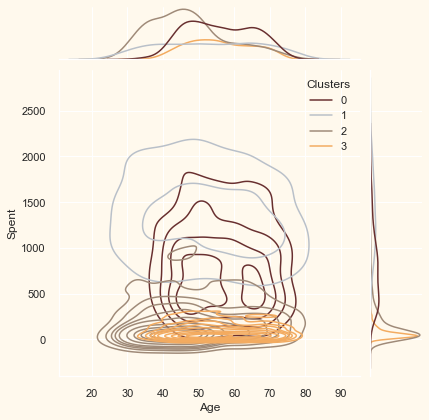

<Figure size 576x396 with 0 Axes>

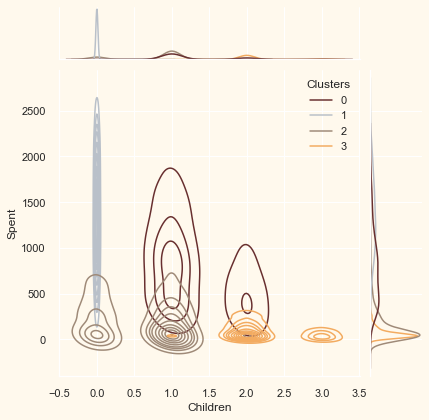

<Figure size 576x396 with 0 Axes>

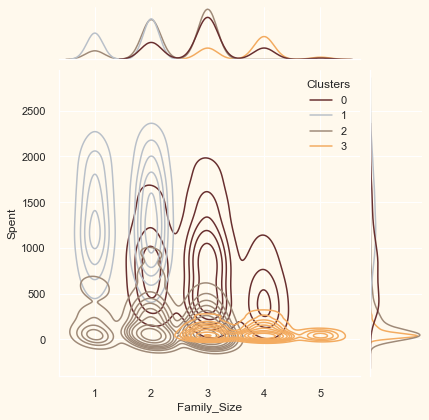

<Figure size 576x396 with 0 Axes>

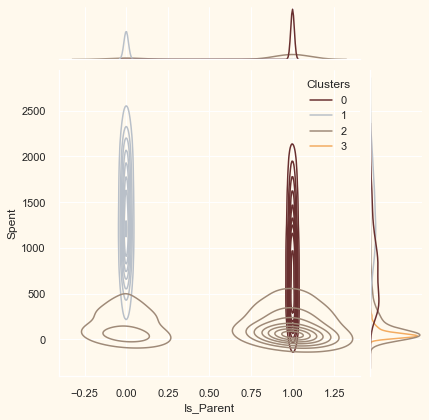

<Figure size 576x396 with 0 Axes>

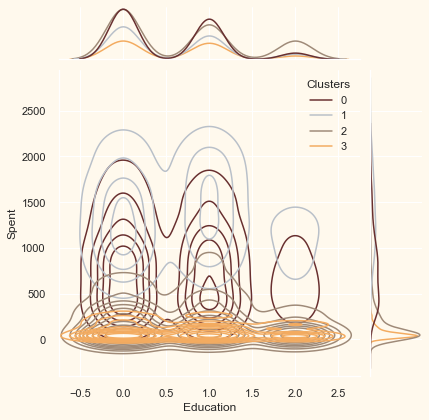

<Figure size 576x396 with 0 Axes>

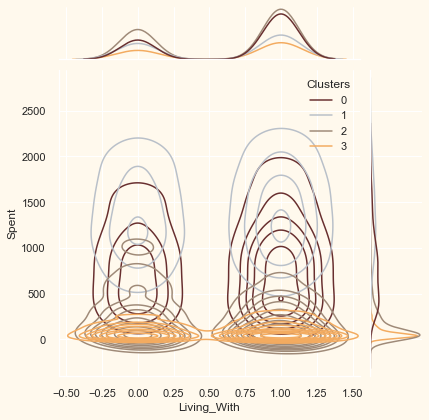

In [103]:
## spent와 Personal_list 안에 있는 변수들을 축으로 두고 jointplot -> cluster의 특징 찾아내기!

Personal_list = ["Kidhome","Teenhome","Customer_For",
                 "Age", "Children", "Family_Size",
                 "Is_Parent", "Education","Living_With"]


fig = plt.figure(figsize=(24, 9*3))
for i, col in enumerate(Personal_list):
    plt.figure()
    sns.jointplot(x=data[col], y=data["Spent"], hue = data["Clusters"], kind="kde", palette=pal)
    plt.show()

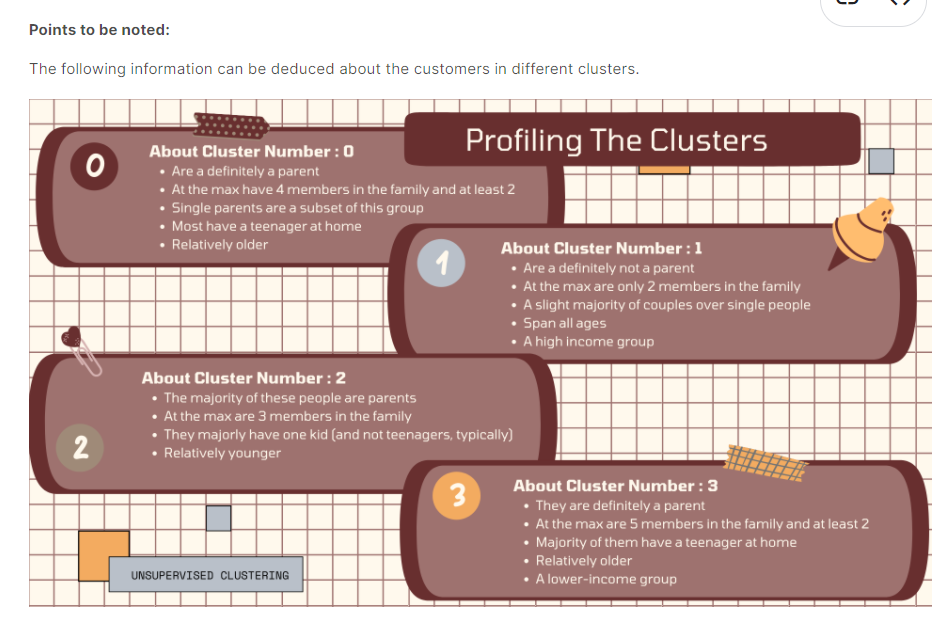

## CONCLUSION

> In this project, I performed unsupervised clustering. I did use dimensionality reduction followed by agglomerative clustering. I came up with 4 clusters and further used them in profiling customers in clusters according to their family structures and income/spending. This can be used in planning better marketing strategies.